<a href="https://colab.research.google.com/github/vaguiar/camelyon_dl_2019/blob/data-exploration/training_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip  install tf-nightly-2.0-preview

     |████████████████████████████████| 87.5MB 120kB/s 
     |████████████████████████████████| 61kB 21.2MB/s 
     |████████████████████████████████| 3.1MB 33.9MB/s 
     |████████████████████████████████| 430kB 28.3MB/s 
  Stored in directory: /root/.cache/pip/wheels/89/67/41/63cbf0f6ac0a6156588b9587be4db5565f8c6d8ccef98202fc
Successfully built wrapt
ERROR: thinc 6.12.1 has requirement wrapt<1.11.0,>=1.10.0, but you'll have wrapt 1.11.1 which is incompatible.
  Found existing installation: wrapt 1.10.11
    Uninstalling wrapt-1.10.11:
      Successfully uninstalled wrapt-1.10.11


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os

# The code in this notebook should work identically in TF v1 and v2
import tensorflow as tf
import zipfile

import tensorflow.keras.applications as applications
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("You have version", tf.__version__)
assert tf.__version__ >= "2.0" # TensorFlow ≥ 2.0 required

You have version 2.0.0-dev20190511


### Global constants

In [0]:
# Images will be resized to(TARGET_SHAPE, TARGET_SHAPE) as they're read off disk.
TARGET_SHAPE = 150 
BATCH_SIZE = 25

CLASS_MODE = 'categorical'

NUM_OF_CLASSES = 2
CLASS_NAMES = ['tumor', 'non_tumor']

#################
EPOCHS = 50

### Setting up GCP

In [0]:
GCP_PROJECT_ID = 'triple-voyage-239123'
GCP_BUCKET_NAME = 'vaa2114_dl_2019'

In [6]:
!gcloud config set project {GCP_PROJECT_ID}

Updated property [core/project].


To take a quick anonymous survey, run:
  $ gcloud alpha survey



### Read Data from GCP

In [0]:
TRAIN_DIR = "/tmp/train/"
TEST_DIR = "/tmp/test/"

GCP_TRAIN_DIR = "train/level5/"
GCP_TEST_DIR = "test/level5/"

!mkdir -p '$TRAIN_DIR'
!mkdir -p '$TEST_DIR'


### Download Level 5 data into Training Dir

In [8]:
# Download train file.
!gsutil -m cp -r gs://{GCP_BUCKET_NAME}/{GCP_TRAIN_DIR} {TRAIN_DIR}
  

Copying gs://vaa2114_dl_2019/train/level5/non_tumor/level_5_0_108800_tumor_078.tif...
Copying gs://vaa2114_dl_2019/train/level5/non_tumor/level_5_0_217600_tumor_035.tif...
Copying gs://vaa2114_dl_2019/train/level5/non_tumor/level_5_0_96000_tumor_094.tif...
Copying gs://vaa2114_dl_2019/train/level5/non_tumor/level_5_102400_12800_tumor_094.tif...
Copying gs://vaa2114_dl_2019/train/level5/non_tumor/level_5_0_217600_tumor_057.tif...
Copying gs://vaa2114_dl_2019/train/level5/non_tumor/level_5_102400_19200_tumor_094.tif...
Copying gs://vaa2114_dl_2019/train/level5/non_tumor/level_5_102400_19200_tumor_101.tif...
Copying gs://vaa2114_dl_2019/train/level5/non_tumor/level_5_102400_25600_tumor_096.tif...
Copying gs://vaa2114_dl_2019/train/level5/non_tumor/level_5_102400_25600_tumor_101.tif...
Copying gs://vaa2114_dl_2019/train/level5/non_tumor/level_5_102400_25600_tumor_094.tif...
Copying gs://vaa2114_dl_2019/train/level5/non_tumor/level_5_102400_32000_tumor_096.tif...
Copying gs://vaa2114_dl_201

In [9]:

# Download test file.
!gsutil -m cp -r gs://{GCP_BUCKET_NAME}/{GCP_TEST_DIR} {TEST_DIR}

Copying gs://vaa2114_dl_2019/test/level5/non_tumor/level_5_0_0_tumor_001.tif...
Copying gs://vaa2114_dl_2019/test/level5/non_tumor/level_5_0_0_tumor_059.tif...
Copying gs://vaa2114_dl_2019/test/level5/non_tumor/level_5_0_121600_tumor_001.tif...
Copying gs://vaa2114_dl_2019/test/level5/non_tumor/level_5_0_128000_tumor_001.tif...
Copying gs://vaa2114_dl_2019/test/level5/non_tumor/level_5_12800_0_tumor_059.tif...
Copying gs://vaa2114_dl_2019/test/level5/non_tumor/level_5_0_217600_tumor_001.tif...
Copying gs://vaa2114_dl_2019/test/level5/non_tumor/level_5_12800_0_tumor_001.tif...
Copying gs://vaa2114_dl_2019/test/level5/non_tumor/level_5_0_134400_tumor_001.tif...
Copying gs://vaa2114_dl_2019/test/level5/non_tumor/level_5_12800_12800_tumor_001.tif...
Copying gs://vaa2114_dl_2019/test/level5/non_tumor/level_5_12800_12800_tumor_059.tif...
Copying gs://vaa2114_dl_2019/test/level5/non_tumor/level_5_12800_19200_tumor_084.tif...
Copying gs://vaa2114_dl_2019/test/level5/non_tumor/level_5_12800_256

In [0]:
!find /tmp/train/level5/non_tumor -type f -print0 | sort -zR | tail -zn +151 | xargs -0 rm

In [0]:
!find /tmp/train/level5/tumor -type f -print0 | sort -zR | tail -zn +151 | xargs -0 rm

In [0]:
!find /tmp/test/level5/non_tumor -type f -print0 | sort -zR | tail -zn +51 | xargs -0 rm
!find /tmp/test/level5/tumor -type f -print0 | sort -zR | tail -zn +51 | xargs -0 rm

### Util functions

In [28]:
train_dir = '/tmp/train/level5'
val_dir = '/tmp/test/level5'

train_tumor_dir = os.path.join(train_dir, "tumor")
train_non_tumor_dir = os.path.join(train_dir, "non_tumor")

val_tumor_dir = os.path.join(val_dir, "tumor")
val_non_tumor_dir = os.path.join(val_dir, "non_tumor")


tot_train_tumor = len(os.listdir(train_tumor_dir))
tot_train_non_tumor = len(os.listdir(train_non_tumor_dir))

tot_val_tumor = len(os.listdir(val_tumor_dir))
tot_val_non_tumor = len(os.listdir(val_non_tumor_dir))

total_train = tot_train_tumor + tot_train_non_tumor
total_val = tot_val_tumor + tot_val_non_tumor

print(total_train)

300


In [0]:
# Images will be resized to(TARGET_SHAPE, TARGET_SHAPE) as they're read off disk.
TARGET_SHAPE = 160
BATCH_SIZE = 32
NUM_CLASSES = 2

In [30]:
CLASS_MODE = 'categorical'

# train test
image_gen_train = ImageDataGenerator(rescale=1./255)
train_data_gen = image_gen_train.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=train_dir, 
    shuffle=True, 
    target_size=(TARGET_SHAPE,TARGET_SHAPE),
    class_mode=CLASS_MODE)

# Validation data should not be augmented!
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=val_dir, 
    target_size=(TARGET_SHAPE, TARGET_SHAPE),
    class_mode=CLASS_MODE)

Found 300 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [0]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(12,12))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.grid(False)
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

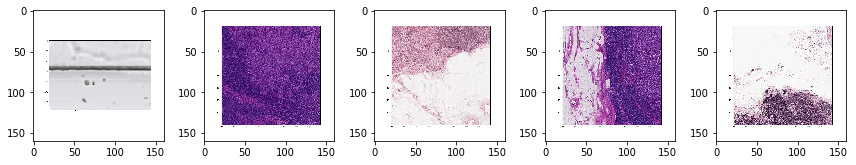

[[1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


In [32]:
sample_training_images, sample_training_labels = next(train_data_gen)
plotImages(sample_training_images[:5])
print(sample_training_labels[:5])

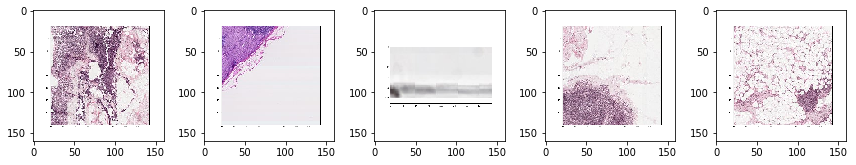

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [33]:
val_images, val_labels = next(val_data_gen)
plotImages(val_images)
val_labels 

In [0]:
def getModel(conv_base):
  model = Sequential()
  model.add(conv_base)
  model.add(Flatten())
  model.add(Dropout(0.5))
  model.add(Dense(216, activation='relu'))
  model.add(Dense(NUM_CLASSES, activation='softmax'))
  
  return model

# Compile and build

def trainModel(model, total_train, total_val, 
               train_data_gen, val_data_gen, EPOCHS):
  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['acc'])

  history = model.fit_generator(
        train_data_gen,
        steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
        epochs=EPOCHS,
        validation_data=val_data_gen,
        validation_steps=int(np.ceil(total_val / float(BATCH_SIZE))),
        verbose=2)
  
  return history

import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [35]:
conv_base = applications.MobileNet(weights='imagenet',include_top=False, 
                               input_shape=(TARGET_SHAPE, TARGET_SHAPE, 3))

17227776/17225924 [==============================] - 1s 0us/step


In [36]:
model = getModel(conv_base)

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_160 (Model)   (None, 5, 5, 1024)        3228864   
_________________________________________________________________
flatten (Flatten)            (None, 25600)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25600)             0         
_________________________________________________________________
dense (Dense)                (None, 216)               5529816   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 434       
Total params: 8,759,114
Trainable params: 8,737,226
Non-trainable params: 21,888
_________________________________________________________________


In [37]:
history = trainModel(model, total_train, total_val, 
               train_data_gen, val_data_gen, 10)

Epoch 1/10
10/10 - 90s - loss: 6.1385 - acc: 0.5300 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 2/10
10/10 - 61s - loss: 5.0144 - acc: 0.6567 - val_loss: 6.6194 - val_acc: 0.6000
Epoch 3/10
10/10 - 61s - loss: 5.1729 - acc: 0.6633 - val_loss: 6.7882 - val_acc: 0.5300
Epoch 4/10
10/10 - 60s - loss: 4.7428 - acc: 0.6900 - val_loss: 5.6825 - val_acc: 0.6700
Epoch 5/10
10/10 - 60s - loss: 4.7660 - acc: 0.6833 - val_loss: 3.4589 - val_acc: 0.7000
Epoch 6/10
10/10 - 60s - loss: 5.8012 - acc: 0.6433 - val_loss: 6.0001 - val_acc: 0.5700
Epoch 7/10
10/10 - 60s - loss: 6.1461 - acc: 0.6233 - val_loss: 4.1333 - val_acc: 0.7000
Epoch 8/10
10/10 - 61s - loss: 6.2397 - acc: 0.6200 - val_loss: 7.2062 - val_acc: 0.5500
Epoch 9/10
10/10 - 69s - loss: 5.3056 - acc: 0.6800 - val_loss: 4.9318 - val_acc: 0.5900
Epoch 10/10
10/10 - 66s - loss: 5.1239 - acc: 0.6733 - val_loss: 5.5110 - val_acc: 0.6300


Confusion matrix, without normalization
[[ 8  6]
 [ 5 13]]


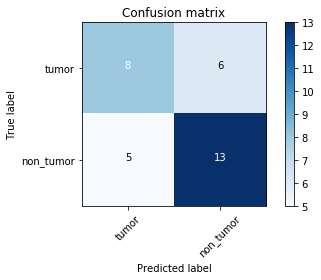

In [38]:
predictions1 = model.predict(val_images)
y_pred_1= np.argmax(predictions1, axis=1)

confusion_matrix_1 = confusion_matrix(np.argmax(val_labels, axis=1), y_pred_1)
plot_confusion_matrix(confusion_matrix_1, CLASS_NAMES)